In [1]:
%matplotlib inline

In [2]:
!pip install wget pysptools

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



# Spectral Unmixing


Suhas Somnath, Rama K. Vasudevan, Stephen Jesse

* Institute for Functional Imaging of Materials
* Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

In this notebook we load some spectral data, and perform basic data analysis, including:
========================================================================================
* Singular Value Decomposition
* Non-Negative Matrix Factorization
* Independent Component Analysis
* n-FINDR

Software Prerequisites:
=======================
* Standard distribution of **Anaconda** (includes numpy, scipy, matplotlib and sci-kit learn)
* **pycroscopy** : Though pycroscopy is mainly used here for plotting purposes only, it's true capabilities
  are realized through the ability to seamlessly perform these analyses on any imaging dataset (regardless
  of origin, size, complexity) and storing the results back into the same dataset among other things




In [3]:
# Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Plotting and visualization:
import matplotlib.pyplot as plt

# for downloading files:
import wget
import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, FastICA
import subprocess
import sys

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
# finally import pycroscopy:
try:
    import pyUSID as usid
except ImportError:
    print('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid
try:
    import pycroscopy as px
except ImportError:
    print('pycroscopy not found.  Will install with pip.')
    import pip
    install('pycroscopy')
    import pycroscopy as px
    
from pycroscopy.viz import cluster_utils

/Users/rvv/anaconda3/lib/python3.6/site-packages/pycroscopy/__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


# Dataset

The data we will be working with is a STEM image of an oxide catalyst. <br>

The image is courtesy of A. Borisevich (ORNL) and Q. He (Manchester)

The image was processed using a sliding window method, to generate local 2D FFT spectra associated with individual locations within the image. We effectively have a stack of 2D images to analyze, which we can do so using multivariate analysis tools.

In [4]:
data_file_path = '../Data/SuperImage2.h5'

h5_file = h5py.File(data_file_path, mode='r+')

usid.hdf_utils.print_tree(h5_file)




/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-FFT_Window_000
      -----------------------
      ├ FFT_Data
      ├ FFT_Data-Cluster_000
        --------------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
      ├ FFT_Data-Cluster_001
        --------------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
      ├ FFT_Data-Cluster_002
        --------------------
        ├ Cluster_Indices
        ├ Cluster_Values
        ├ Labels
        ├ Mean_Resp_Pos_Indices
        ├ Mean_Resp_Pos_Values
        ├ Mean_Response
      ├ FFT_Data-Decomposition_000
        --------------------------
        ├ Components
        ├ Position_Indices
        ├ Position_Values
        ├ 

In [5]:
#Get the image
h5_meas_grp = h5_file['Measurement_000']

h5_image =  h5_meas_grp['Channel_000/Raw_Data']

#Convert to USID Dataset
h5_image = usid.USIDataset(h5_image)

# Getting a reference to the main spectral dataset:
h5_main = usid.USIDataset(h5_meas_grp['Channel_000/Raw_Data-FFT_Window_000/FFT_Data'])

print('Data currently of shape:', h5_main.shape)

[num_rows,num_cols] = h5_main.pos_dim_sizes
num_spect = h5_main.spec_dim_sizes[0]


Data currently of shape: (1024, 16384)


In [6]:
h5_main

<HDF5 dataset "FFT_Data": shape (1024, 16384), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data 
Data contains: 
	FFT (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 32 
	Y - size: 32 
Spectroscopic Dimensions: 
	U_X - size: 128 
	U_Y - size: 128
Data Type:
	float32

(<Figure size 1080x1080 with 18 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x1c2015d2e8>)

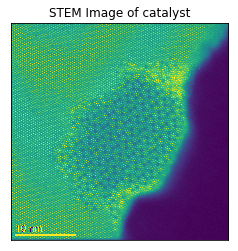

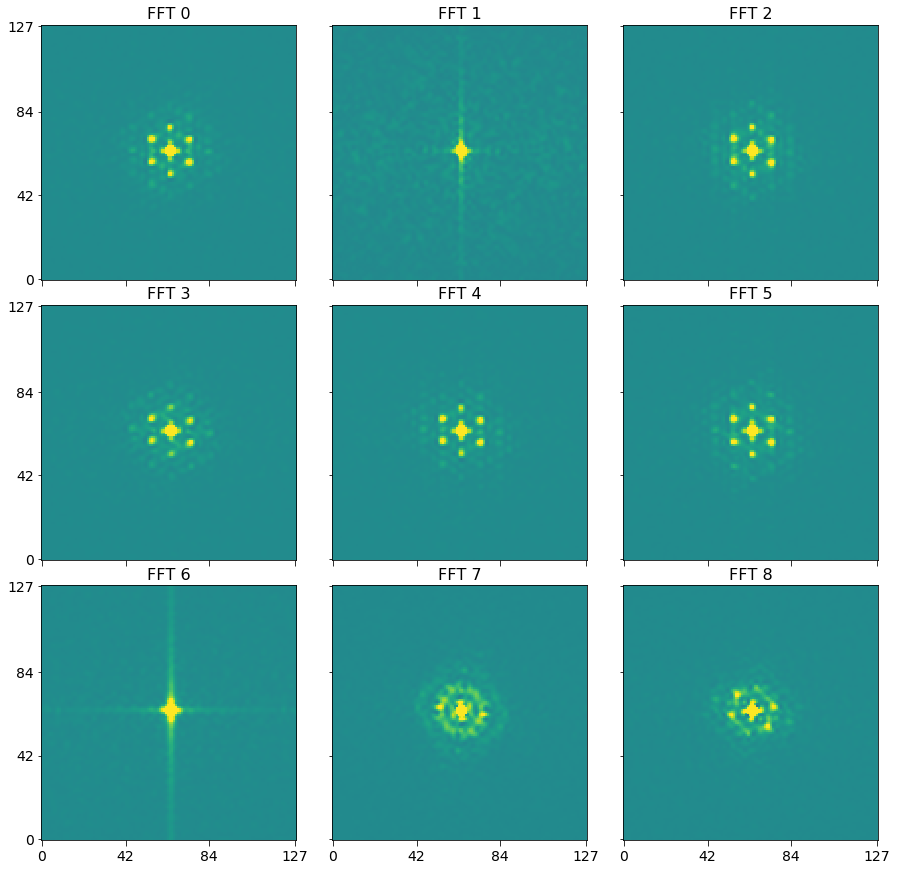

In [7]:
#Plot the image, and some spectra

fig, axes = plt.subplots()
axes.imshow(np.flipud(h5_image.get_n_dim_form()[:,:,0]));
axes.set_title('STEM Image of catalyst')
axes.set_xticks([]);
axes.set_yticks([]);

FFT_mat = h5_main.get_n_dim_form().reshape(h5_main.pos_dim_sizes[0]*h5_main.pos_dim_sizes[1], h5_main.spec_dim_sizes[0], h5_main.spec_dim_sizes[1])

random_indices = np.random.randint(low = 0, high = FFT_mat.shape[0], size = 9)

#Now plot some FFT windows
usid.plot_utils.use_nice_plot_params();

usid.plot_utils.plot_map_stack(FFT_mat[random_indices,:,:], subtitle= "FFT", title = '')

1. Singular Value Decomposition (SVD)
=====================================

SVD is an eigenvector decomposition that is defined statistically, and therefore typically produces
non-physical eigenvectors. Consequently, the interpretation of eigenvectors and abundance maps from
SVD requires care and caution in interpretation. Nonetheless, it is a good method for quickly
visualizing the major trends in the dataset since the resultant eigenvectors are sorted in descending
order of variance or importance. Furthermore, SVD is also very well suited for data cleaning through
the reconstruction of the dataset using only the first N (most significant) components.

SVD results in three matrices:

* V - Eigenvectors sorted by variance in descending order
* U - corresponding abundance maps
* S - Variance or importance of each of these components

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-SVD_000" (7 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-SVD_000
set the "override" flag to True to recompute results


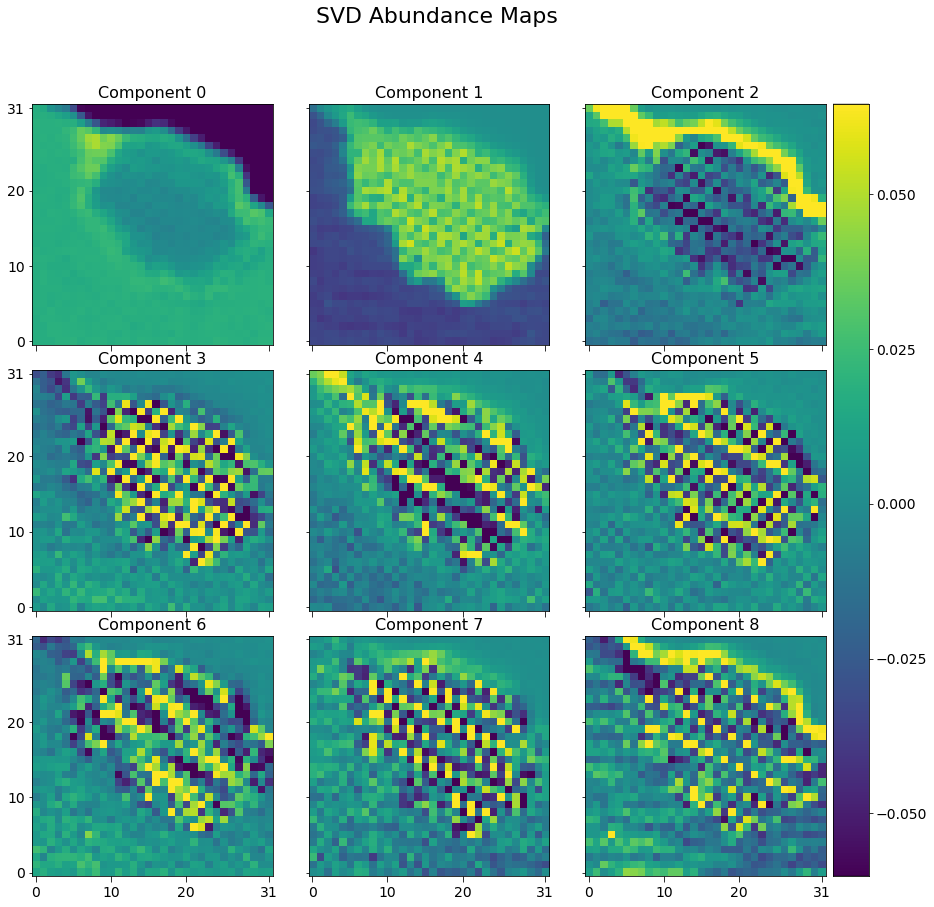

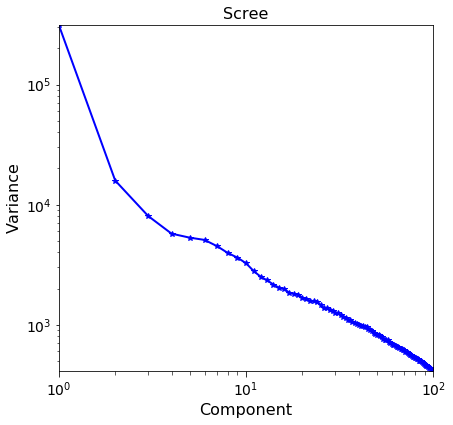

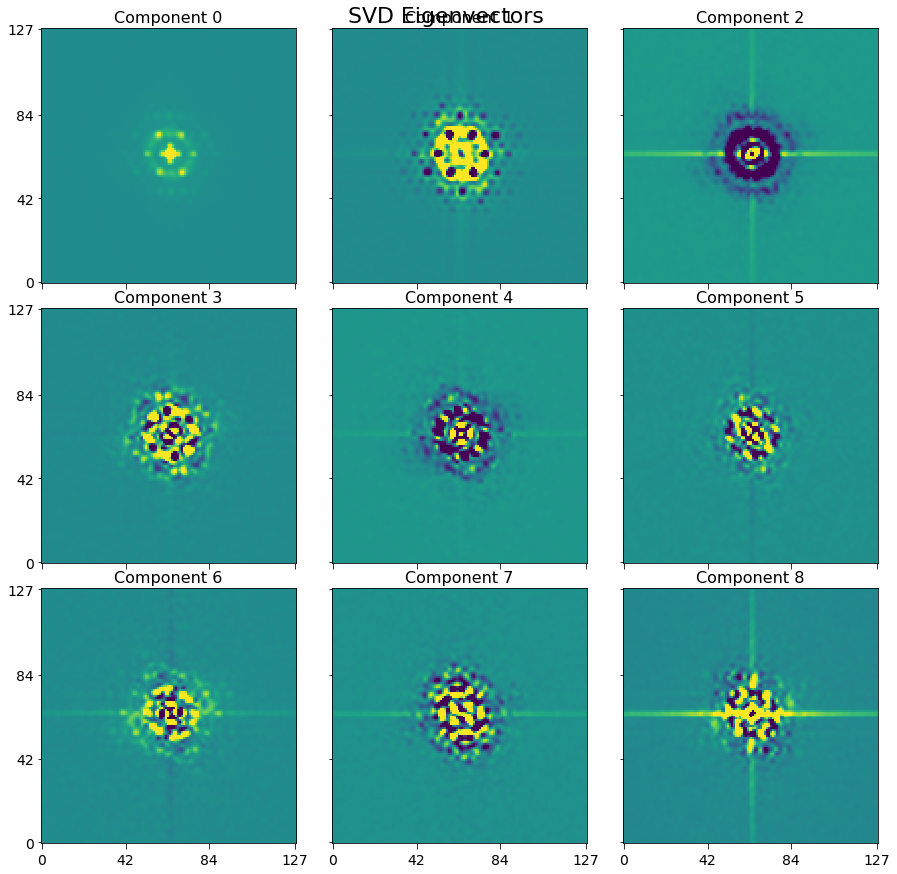

In [8]:
decomposer = px.processing.svd_utils.SVD(h5_main, num_components=100)
h5_svd_group = decomposer.compute()

h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:, :25], (num_rows, num_cols, -1))

usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='viridis', title_yoffset=0.95)


# Visualize the variance / statistical importance of each component:
usid.plot_utils.plot_scree(h5_s, title='Scree')

# Visualize the eigenvectors:
_ = usid.plot_utils.plot_map_stack(h5_v[:9, :].reshape(9,h5_main.spec_dim_sizes[0],h5_main.spec_dim_sizes[1]), 
                                       title='SVD Eigenvectors', evenly_spaced=False)

# 2. Non-negative Matrix Factorization (NMF)
===========================================

NMF, or non-negative matrix factorization, is a method that is useful towards unmixing of spectral
data. It only works on data with positive real values. It operates by approximate determination of
factors (matrices) W and H, given a matrix V, as shown below

![](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)


Unlike SVD and k-Means that can be applied to complex-valued datasets, NMF only works on non-negative datasets.
For illustrative purposes, we will only take the amplitude component of the spectral data



Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-Decomposition_000" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-Decomposition_000
set the "override" flag to True to recompute results


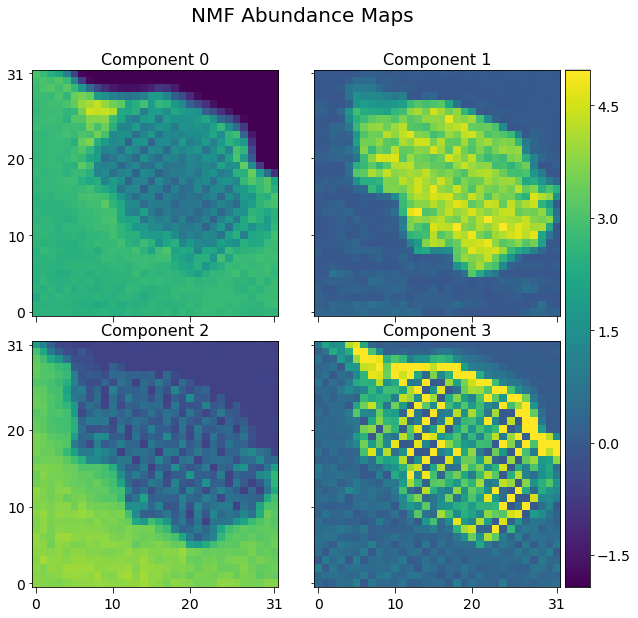

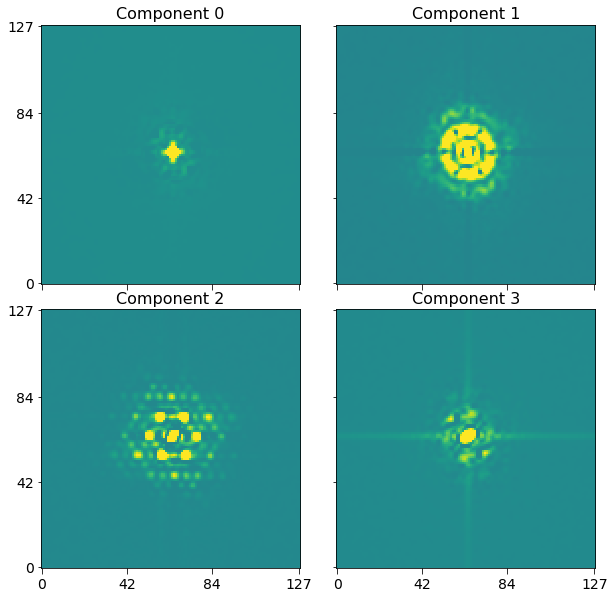

In [9]:
num_comps = 4

#Choose the NMFmodel from sklearn
nmf_model = NMF(n_components=num_comps, init='random', random_state=0)

data_mat = np.abs(h5_main[:]) #get the data, ensuring it is positive only.

#pycroscopy can handle this decomposition given an sklearn estimator object
decomposer = px.processing.decomposition.Decomposition(h5_main, estimator =nmf_model)
h5_nmf_group = decomposer.compute() #compute it. Saves results into the file and returns reference to it.

components = h5_nmf_group['Components'] #Components 
projection  = h5_nmf_group['Projection'] #Coefficients/scores

nmf_coeffs_fig = usid.plot_utils.plot_map_stack(projection[:].reshape(h5_main.pos_dim_sizes[0],h5_main.pos_dim_sizes[1],-1), num_comps=9, title='NMF Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='viridis', title_yoffset=0.95)

# Visualize the components:
nmf_components_fig = usid.plot_utils.plot_map_stack(components[:].reshape(num_comps, h5_main.spec_dim_sizes[0], h5_main.spec_dim_sizes[1]), title = '')

# 3. Independent Component Analysis (ICA)
===========================================

ICA can be a useful tool when the signal arises from multiple independent sources. From a physics perspective if there are multiple mechanisms that produce the measured signal that have limited interaction between each other, then ICA can be a useful tool. Unfortauntely, as with SVD or PCA, the components often end up having unphysical values. Still, it can be insightful (for an instructive example, see Vasudevan et al., Journal of Applied Physics 118, 072003 (2015)).

As with NMF, the user must specify the number of components to use. In practice, one can always start with a high number (e.g., 10) and reduce them until no two components look 'alike'. More rigorous mathematical methods to determine the otpimal number of components are also possible, but are beyond the scope of this workshop. The distinction between NMF and ICA is that ICA allows negativity in the matrices, and the components are chosen such that independence of components(defined in some mathematical way, such as maximally non-Gaussian) is obtained.

The algorithm used is the FastICA algorithm implemented in scikit-learn, which is based on A. Hyvarinen and E. Oja, Independent Component Analysis: Algorithms and Applications, Neural Networks, 13(4-5), 2000, pp. 411-430

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-Decomposition_001" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Data-Decomposition_001
set the "override" flag to True to recompute results
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-FFT_Window_000/FFT_Dat

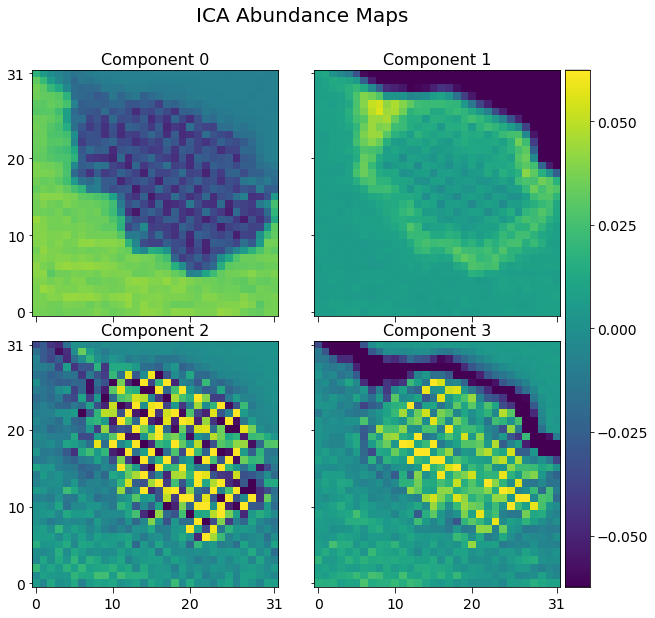

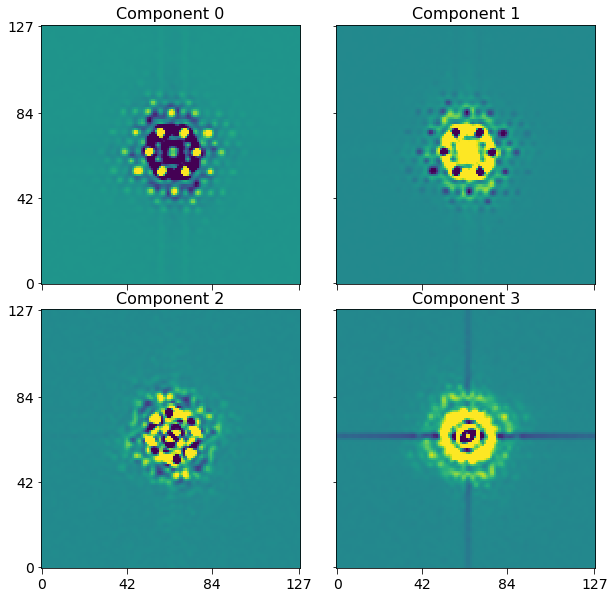

In [10]:
num_comps = 4

#Choose the ICA model from sklearn
ica_model = FastICA(n_components=num_comps, max_iter=200)

# get the data
data_mat = h5_main[:]

decomposer = px.processing.decomposition.Decomposition(h5_main, estimator = ica_model)
h5_ica_group = decomposer.compute()

#pycroscopy can handle this decomposition given an sklearn estimator object
decomposer = px.processing.decomposition.Decomposition(h5_main, estimator =ica_model)
h5_ica_group = decomposer.compute() #compute it. Saves results into the file and returns reference to it.

components = h5_ica_group['Components'] #Components 
projection  = h5_ica_group['Projection'] #Coefficients/scores

ica_coeffs_fig = usid.plot_utils.plot_map_stack(projection[:].reshape(num_rows,num_cols,-1), num_comps=9, title='ICA Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='viridis', title_yoffset=0.95)

# Visualize the components:
# Visualize the components:
ica_components_fig = usid.plot_utils.plot_map_stack(components[:].reshape(num_comps, h5_main.spec_dim_sizes[0], h5_main.spec_dim_sizes[1]), title = '')

# 4. N-FINDR

The N-FINDR algorithm is useful in situations where the basis spectra are already present in the dataset. For our case, this means that at least some of our windows capture individual phases that are present, i.e. not all windows contain FFTs from multiple phases. Note that the linearity of imaging process is paramount. In cases where we cannot assume the linearity, more complex methods will be needed for the spectral decomposition.

The N-FINDR method utilizes the implemenetation found in pysptools. Details on the algorithm can be found in the paper by M. Winter 

https://www.spiedigitallibrary.org/conference-proceedings-of-spie/3753/1/N-FINDR--an-algorithm-for-fast-autonomous-spectral-end/10.1117/12.366289.full?SSO=1



(<Figure size 1080x360 with 6 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x1c1db456a0>)

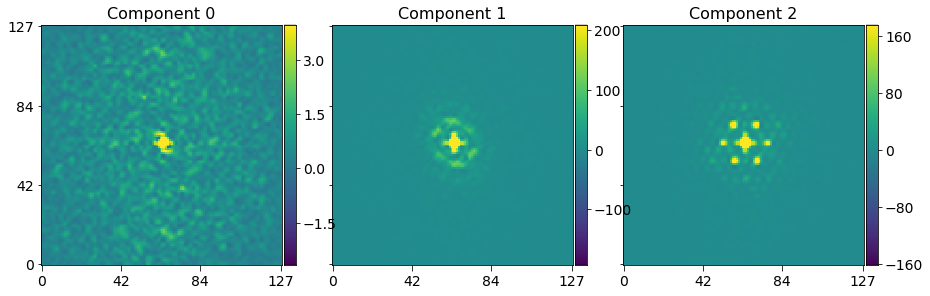

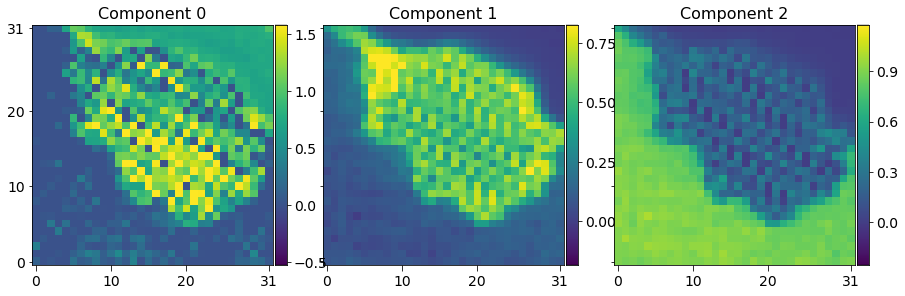

In [11]:
#Let us try on this dataset

#Load the NFIND-R implementation form pysptools
from pysptools.eea import nfindr
import pysptools.abundance_maps as amp

num_endmembers = 3

#Find the endmembers
comps = nfindr.NFINDR(h5_main[:].copy(), num_endmembers)[0]

#Calculate abundance maps
nnls = amp.NNLS() #change to FCLS in case cvxopt is available
abundances = nnls.map(h5_main[:].copy().reshape(h5_main.pos_dim_sizes[0], h5_main.pos_dim_sizes[1], -1), comps)

#Plot results

#Plot the components
usid.plot_utils.plot_map_stack(comps.reshape(num_endmembers, h5_main.spec_dim_sizes[0], h5_main.spec_dim_sizes[1]), 
                               title = '', color_bar_mode='each')

#Plot the abundances
usid.plot_utils.plot_map_stack(abundances.transpose(2,0,1), title = '', color_bar_mode='each')


# Close the file

After processing, good practice to close the file. 

In [12]:
h5_file.close()